# Demonstration of an analysis

This file run a simulation, then get some insights from results.

Hypothesis : 
- All EU countries
- 37 clusters
- Optimizing only electricity
- 8 months, step of 12 hours
- Planning horizons : 2050

## 1. First run a PyPSA simulation

### 1.1. First lets clean up data and display global informations

We want to be explicit about what we will run. Therefore, we will clean up local data. Then, build the planned DAG and appropriated summary.

In [1]:
# To run only once after kernel restart
%cd ../..

/Users/climact/pypsa/pypsa-eur


In [2]:
from pathlib import Path

# Basic parameters to check
run_name = "test-tgi"
config_file = "config.tgi.test.yaml"
rule = "all"

# Derived parameters
graphs_path = Path("analysis",run_name, "graphs")

In [3]:
# Cleaning commands
! snakemake --unlock
#! snakemake -call purge

Unlocking working directory.


Now that everything is clean, let's build graphs.

Config file config.yaml is extended by additional config specified via the command line.
Building DAG of jobs...
Config file config.yaml is extended by additional config specified via the command line.
Building DAG of jobs...
Config file config.yaml is extended by additional config specified via the command line.
Building DAG of jobs...


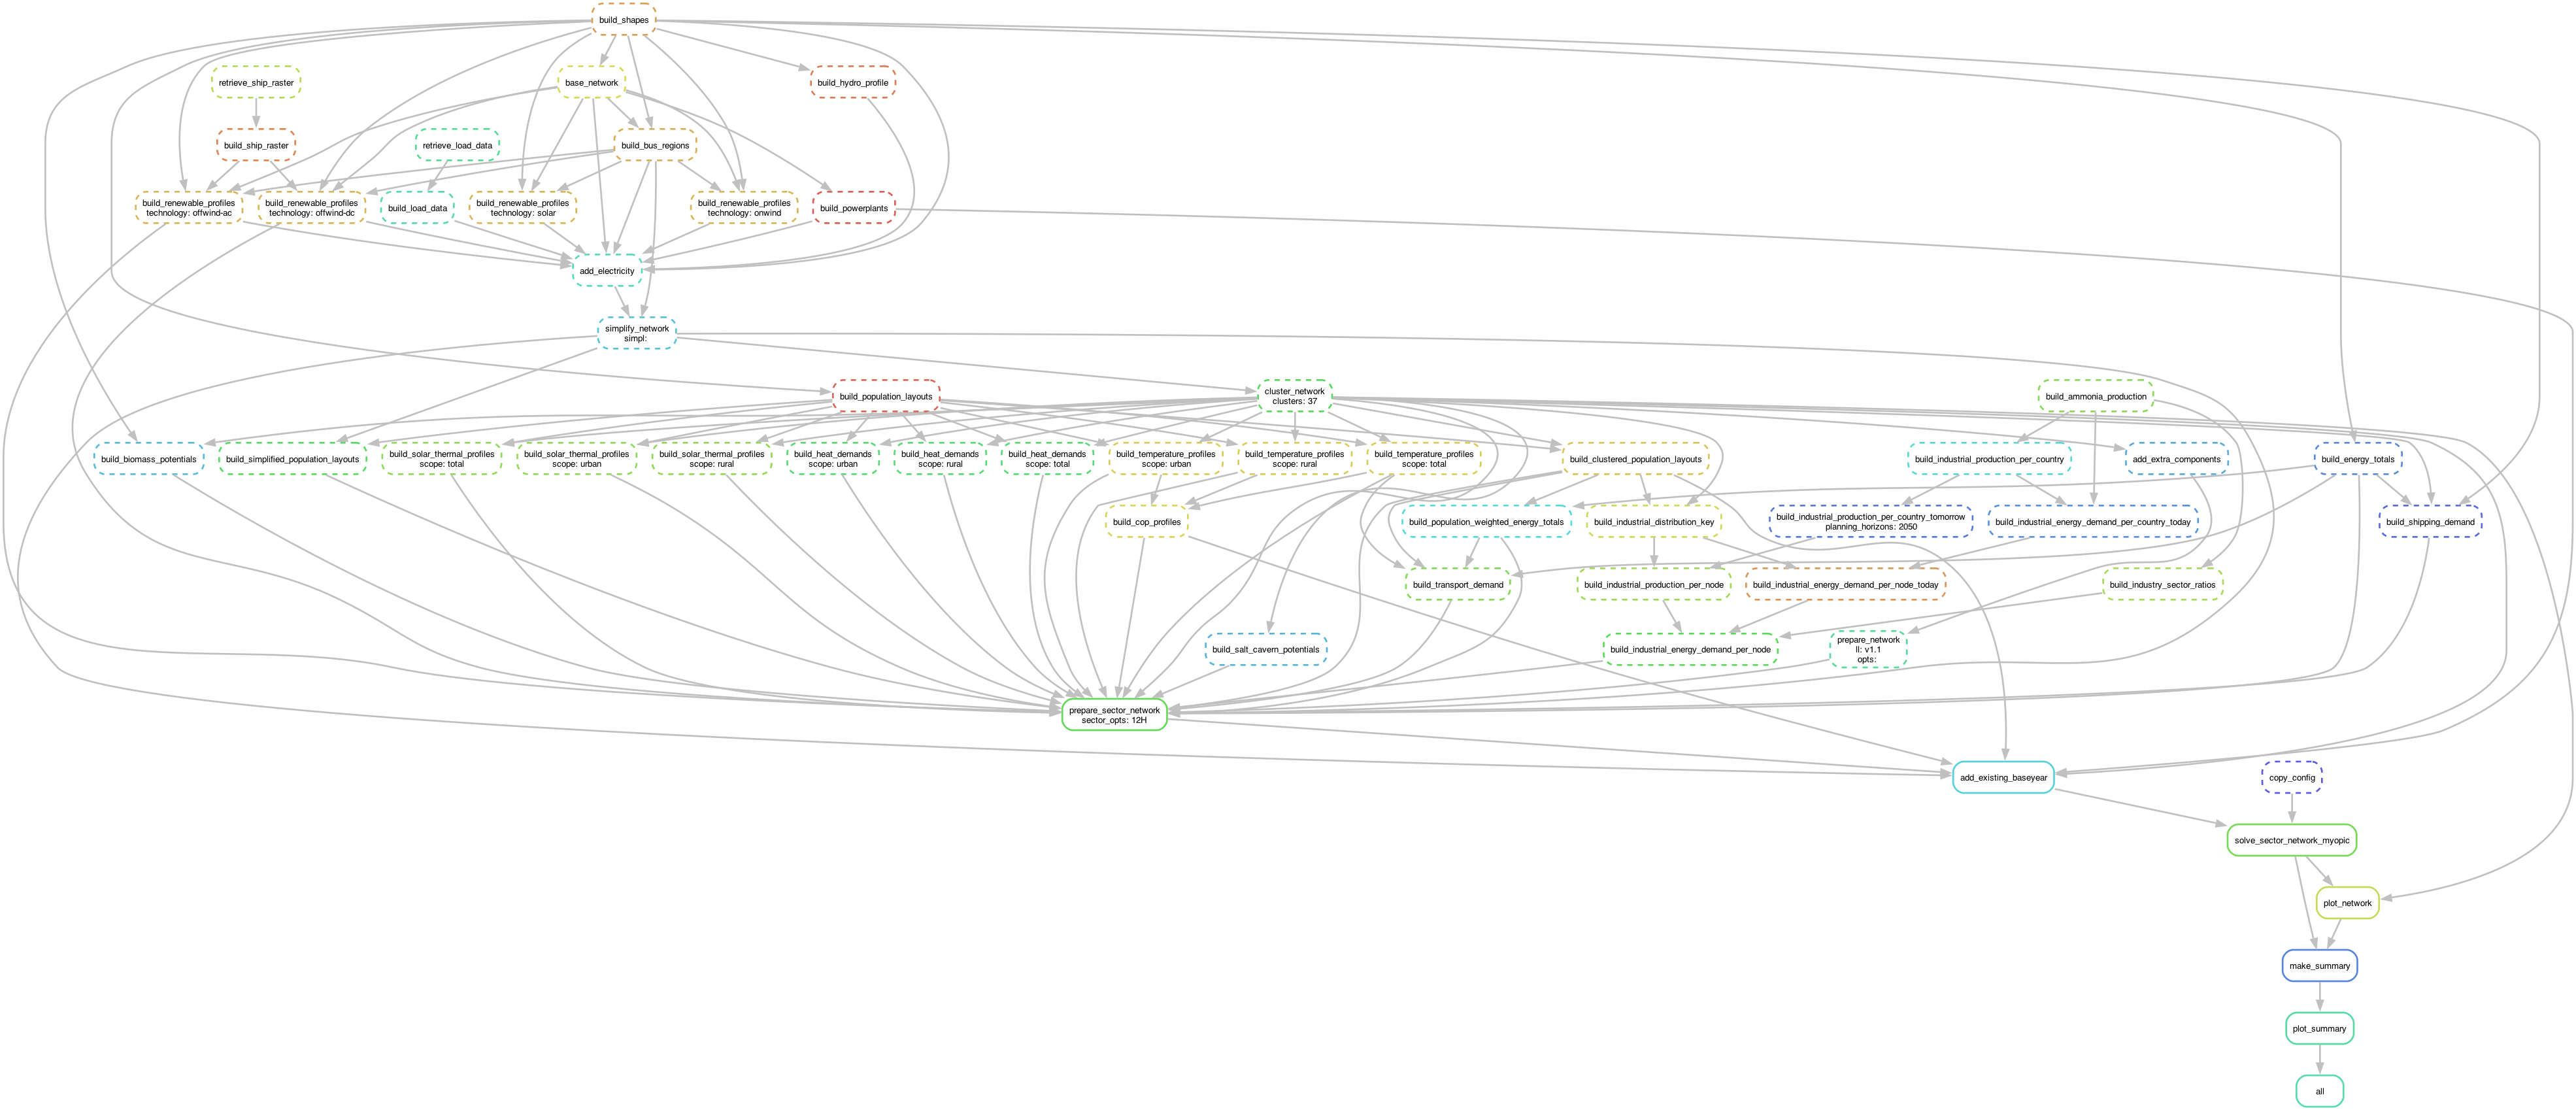

In [37]:
dag = Path(graphs_path, "dag.png")
rulegraph = Path(graphs_path, "rulegraph.png")
filegraph = Path(graphs_path, "filegraph.png")

!snakemake --configfile {config_file} --dag all | dot -Tpng -o {dag}
!snakemake --configfile {config_file} --rulegraph all | dot -Tpng -o {rulegraph}
!snakemake --configfile {config_file} --filegraph all | dot -Tpng -o {filegraph}

from IPython.display import Image
Image(filename=dag)

And let create an overview of output files.

In [5]:
summary = Path(graphs_path, "summary.csv")

!snakemake --configfile {config_file} --detailed-summary all | sed 's/,/;/g' | sed 's/\t/,/g' > {summary}

Config file config.yaml is extended by additional config specified via the command line.
Building DAG of jobs...


### 1.2. Run code

In [6]:
!snakemake -call {rule} --configfile {config_file} --keep-going

Config file config.yaml is extended by additional config specified via the command line.
Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 10
Rules claiming more threads will be scaled down.
Conda environments: ignored
Job stats:
job                                                 count    min threads    max threads
------------------------------------------------  -------  -------------  -------------
add_electricity                                         1              1              1
add_existing_baseyear                                   1              1              1
add_extra_components                                    1              1              1
all                                                     1              1              1
base_network                                            1              1              1
build_ammonia_production                                1              1              1
build_biomass_potentials                             

## 2. Get some information about network

In [169]:
import pypsa
import pandas as pd
from IPython.display import Image

%matplotlib inline
pd.set_option("display.width", 1000)

In [16]:
n = pypsa.Network(Path("results", run_name, "postnetworks", "elec_s_37_lv1.1__12H_2050.nc"))
for c in n.iterate_components(list(n.components.keys())[2:]):
    print(f"Component {c.name} has {len(c.df)} entries.")

INFO:pypsa.io:Imported network elec_s_37_lv1.1__12H_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Component Bus has 192 entries.
Component Carrier has 18 entries.
Component GlobalConstraint has 3 entries.
Component Line has 52 entries.
Component LineType has 34 entries.
Component TransformerType has 14 entries.
Component Link has 657 entries.
Component Load has 37 entries.
Component Generator has 447 entries.
Component StorageUnit has 51 entries.
Component Store has 118 entries.


In [71]:
df_generators = n.generators.merge(n.buses["country"].reset_index(), left_on="bus", right_on="Bus")

<AxesSubplot:title={'center':'Nominal power installed in 2050'}, xlabel='carrier', ylabel='MW'>

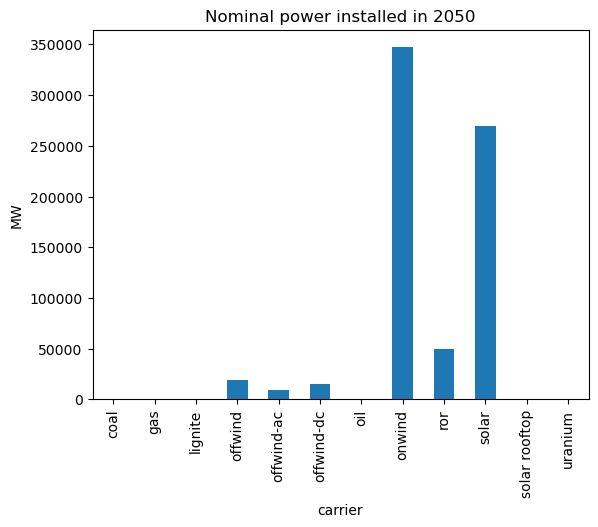

In [75]:
df_generators_eu = df_generators.groupby("carrier").sum()["p_nom"]
df_generators_eu.plot(kind="bar", title=f"Nominal power installed in 2050", ylabel="MW")

<AxesSubplot:title={'center':'Nominal power installed in 2050 (in BE)'}, xlabel='carrier', ylabel='MW'>

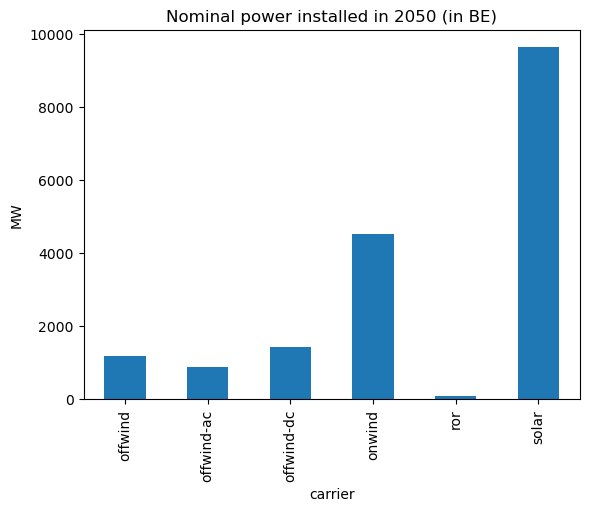

In [76]:
COUNTRY = "BE"

df_generators_countries = df_generators.groupby(["country", "carrier"]).sum()["p_nom"]
df_generators_country = df_generators_countries[df_generators_countries.index.get_level_values(0) == COUNTRY].droplevel(0)
df_generators_country.plot(kind="bar", title=f"Nominal power installed in 2050 (in {COUNTRY})", ylabel="MW")

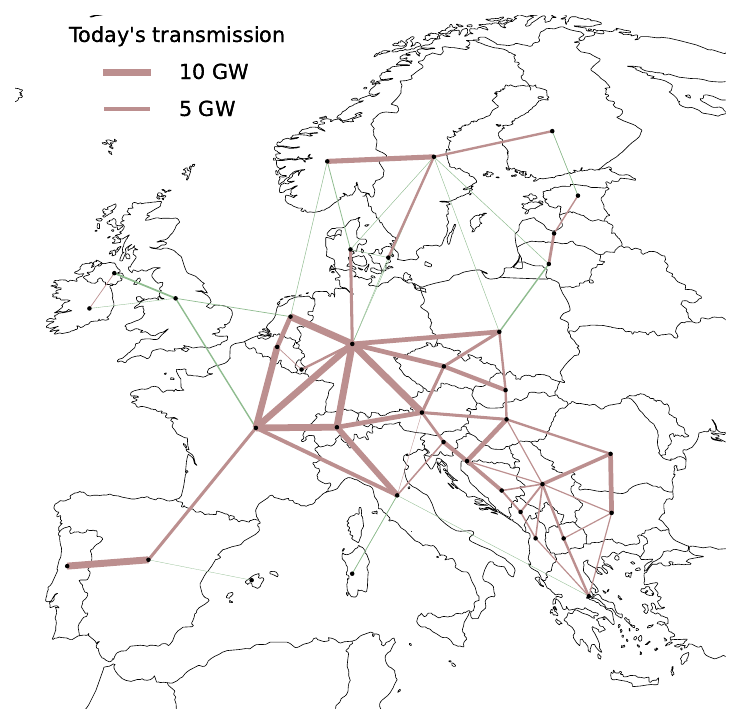

In [185]:
filename = "elec_s_37_lv1.1__12H_2050-today"
path = Path("results", run_name, "maps")
file_pdf = Path(path, filename + ".pdf")
file_png = Path(path, filename)
! pdftoppm {file_pdf} {file_png} -png
display(Image(str(file_png) + "-1.png"))

<AxesSubplot:title={'center':'State of charge of storage units'}, ylabel='MWh'>

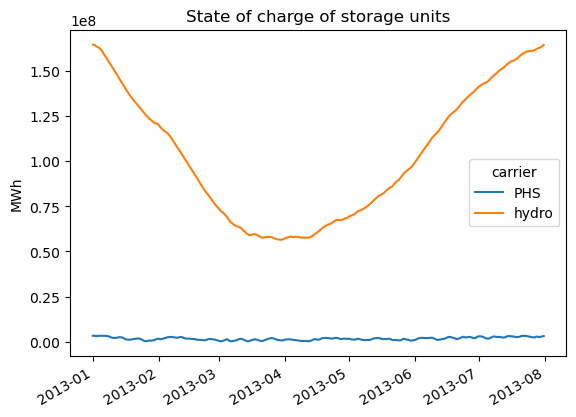

In [80]:
df_storage_units = n.storage_units.reset_index()
df_storage_units = df_storage_units.merge(n.buses["country"].reset_index(), left_on="bus", right_on="Bus")
df_storage_units_t = n.storage_units_t.state_of_charge.T.reset_index()
df_storage_units_t = df_storage_units_t.merge(df_storage_units[["country", "carrier", "StorageUnit"]], on="StorageUnit")
del df_storage_units_t["StorageUnit"]
del df_storage_units_t["country"]
df_storage_units_t.groupby("carrier").sum().T.plot(title="State of charge of storage units", ylabel="MWh")

<AxesSubplot:title={'center':'Electricty load for BE'}, ylabel='MW'>

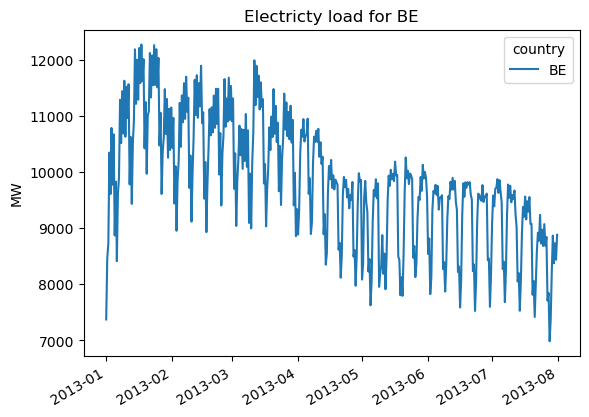

In [164]:
df_loads = n.loads_t["p"].T
df_loads = df_loads.merge(n.buses["country"].reset_index(), left_on="Load", right_on="Bus")
del df_loads["Bus"]
df_loads = df_loads.groupby("country").sum()

df_loads_country = df_loads[df_loads.index == COUNTRY]
df_loads_country.T.plot(title=f"Electricty load for {COUNTRY}", ylabel="MW")
